In [ ]:


import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression


In [ ]:
import pandas as pd

DATA_PATH = "/content/epa_co2_architecture_pathA_v1.parquet"
df = pd.read_parquet(DATA_PATH)

print(df.shape)
df.head()


(9483, 6)


,Model Year,Test Veh Displacement (L),Equivalent Test Weight (lbs.),transmission_bucket,drive_bucket,CO2_combined
0,2010,0.999,2125,AT,RWD,180.078500
1,2010,1.300,3000,CVT,FWD,154.106628
2,2010,1.300,3125,CVT,FWD,151.140680
3,2010,1.300,3375,AT,RWD,344.400000
4,2010,1.300,3375,MT,RWD,355.900000


In [ ]:
df.info()
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9483 entries, 0 to 9482
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Model Year                     9483 non-null   int64  
 1   Test Veh Displacement (L)      9483 non-null   float64
 2   Equivalent Test Weight (lbs.)  9483 non-null   int64  
 3   transmission_bucket            9483 non-null   object 
 4   drive_bucket                   9483 non-null   object 
 5   CO2_combined                   9483 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 444.6+ KB


,Model Year,Test Veh Displacement (L),Equivalent Test Weight (lbs.),transmission_bucket,drive_bucket,CO2_combined
count,9483.000000,9483.000000,9483.000000,9483,9483,9483.000000
unique,NaN,NaN,NaN,3,3,NaN
top,NaN,NaN,NaN,AT,FWD,NaN
freq,NaN,NaN,NaN,6844,3989,NaN
mean,2017.239165,3.149949,4278.656649,NaN,NaN,317.287747
std,4.462617,1.363003,849.557271,NaN,NaN,89.359627
min,2010.000000,0.600000,2125.000000,NaN,NaN,122.173867
25%,2013.000000,2.000000,3625.000000,NaN,NaN,254.395886
50%,2017.000000,2.996000,4250.000000,NaN,NaN,309.030375
75%,2021.000000,3.800000,4750.000000,NaN,NaN,368.024675


In [ ]:
df["Model Year"].value_counts().sort_index()


,count
Model Year,
2010,576
2011,610
2012,618
2013,602
2014,623
2015,649
2016,647
2017,633
2018,643


In [ ]:
SPLIT_YEAR = 2021

df_train = df[df["Model Year"] < SPLIT_YEAR].copy()
df_test  = df[df["Model Year"] >= SPLIT_YEAR].copy()

print("Train shape:", df_train.shape)
print("Test shape :", df_test.shape)
print(
    "Train years:",
    df_train["Model Year"].min(), "-", df_train["Model Year"].max()
)
print(
    "Test years :",
    df_test["Model Year"].min(), "-", df_test["Model Year"].max()
)


Train shape: (6837, 6)
Test shape : (2646, 6)
Train years: 2010 - 2020
Test years : 2021 - 2025


In [ ]:
TARGET = "CO2_combined"

NUM_FEATURES = [
    "Model Year",
    "Test Veh Displacement (L)",
    "Equivalent Test Weight (lbs.)",
]

CAT_FEATURES = [
    "transmission_bucket",
    "drive_bucket",
]


In [ ]:
X_train = df_train[NUM_FEATURES + CAT_FEATURES]
y_train = df_train[TARGET]

X_test = df_test[NUM_FEATURES + CAT_FEATURES]
y_test = df_test[TARGET]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)


X_train shape: (6837, 5)
y_train shape: (6837,)
X_test shape : (2646, 5)
y_test shape : (2646,)


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", NUM_FEATURES),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            CAT_FEATURES,
        ),
    ]
)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression


linreg_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LinearRegression())
    ]
)


In [ ]:
linreg_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Model Year',
                                                   'Test Veh Displacement (L)',
                                                   'Equivalent Test Weight '
                                                   '(lbs.)']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['transmission_bucket',
                                                   'drive_bucket'])])),
                ('model', LinearRegression())])

In [ ]:
y_train_pred = linreg_model.predict(X_train)
y_test_pred = linreg_model.predict(X_test)


In [ ]:
import numpy as np

def evaluate(y_true, y_pred, label=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"{label} R2   : {r2:.3f}")
    print(f"{label} MAE  : {mae:.2f} g/mi")
    print(f"{label} RMSE : {rmse:.2f} g/mi")
    print("-" * 30)



print("TRAIN PERFORMANCE")
evaluate(y_train, y_train_pred, "Train")

print("TEST PERFORMANCE")
evaluate(y_test, y_test_pred, "Test")


TRAIN PERFORMANCE
Train R2   : 0.805
Train MAE  : 27.77 g/mi
Train RMSE : 38.89 g/mi
------------------------------
TEST PERFORMANCE
Test R2   : 0.758
Test MAE  : 33.19 g/mi
Test RMSE : 45.11 g/mi
------------------------------


In [ ]:
# Get feature names after preprocessing
ohe = linreg_model.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(CAT_FEATURES)

feature_names = NUM_FEATURES + list(cat_feature_names)

# Extract coefficients
coeffs = linreg_model.named_steps["model"].coef_

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coeffs
}).sort_values(by="coefficient", key=abs, ascending=False)

coef_df


,feature,coefficient
1,Test Veh Displacement (L),40.066736
4,transmission_bucket_CVT,-31.291164
5,transmission_bucket_MT,20.539054
3,transmission_bucket_AT,10.752111
6,drive_bucket_AWD,9.334392
7,drive_bucket_FWD,-8.381305
0,Model Year,-2.579294
8,drive_bucket_RWD,-0.953086
2,Equivalent Test Weight (lbs.),0.026361


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor


In [ ]:
gbr_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        (
            "model",
            HistGradientBoostingRegressor(
                max_depth=6,
                learning_rate=0.05,
                max_iter=300,
                random_state=42
            )
        )
    ]
)


In [ ]:
gbr_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Model Year',
                                                   'Test Veh Displacement (L)',
                                                   'Equivalent Test Weight '
                                                   '(lbs.)']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['transmission_bucket',
                                                   'drive_bucket'])])),
                ('model',
                 HistGradientBoostingRegressor(learning_rate=0.05, max_depth=6,
                                               max_iter=300,
                                               random_state=42))])

In [ ]:
y_train_pred_gbr = gbr_model.predict(X_train)
y_test_pred_gbr = gbr_model.predict(X_test)

print("TRAIN PERFORMANCE (Tree-based)")
evaluate(y_train, y_train_pred_gbr, "Train")

print("TEST PERFORMANCE (Tree-based)")
evaluate(y_test, y_test_pred_gbr, "Test")


TRAIN PERFORMANCE (Tree-based)
Train R2   : 0.926
Train MAE  : 17.16 g/mi
Train RMSE : 23.97 g/mi
------------------------------
TEST PERFORMANCE (Tree-based)
Test R2   : 0.857
Test MAE  : 25.00 g/mi
Test RMSE : 34.63 g/mi
------------------------------


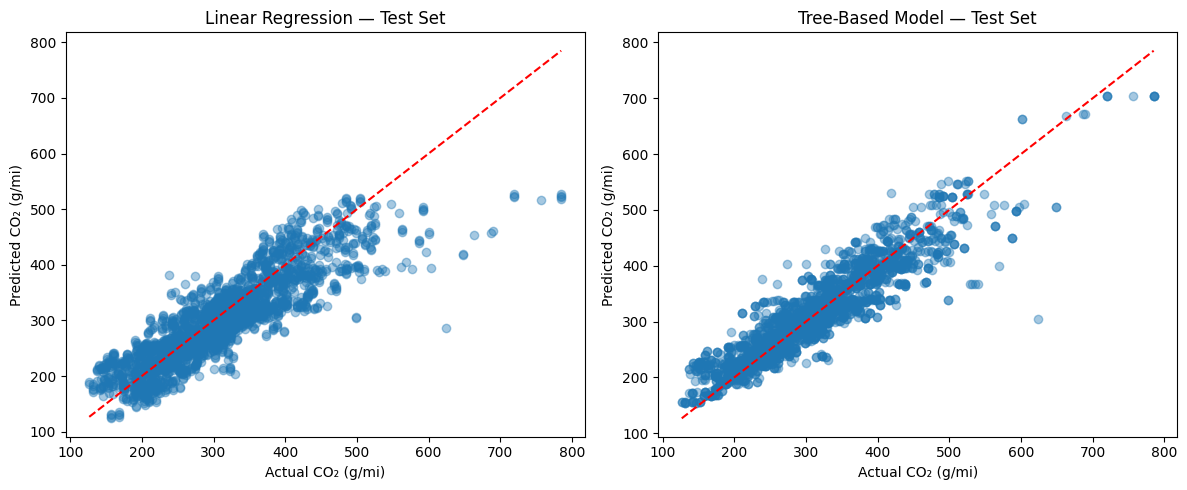

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Linear model
plt.subplot(1,2,1)
plt.scatter(y_test, y_test_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual CO₂ (g/mi)")
plt.ylabel("Predicted CO₂ (g/mi)")
plt.title("Linear Regression — Test Set")

# Tree-based model
plt.subplot(1,2,2)
plt.scatter(y_test, y_test_pred_gbr, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual CO₂ (g/mi)")
plt.ylabel("Predicted CO₂ (g/mi)")
plt.title("Tree-Based Model — Test Set")

plt.tight_layout()
plt.show()


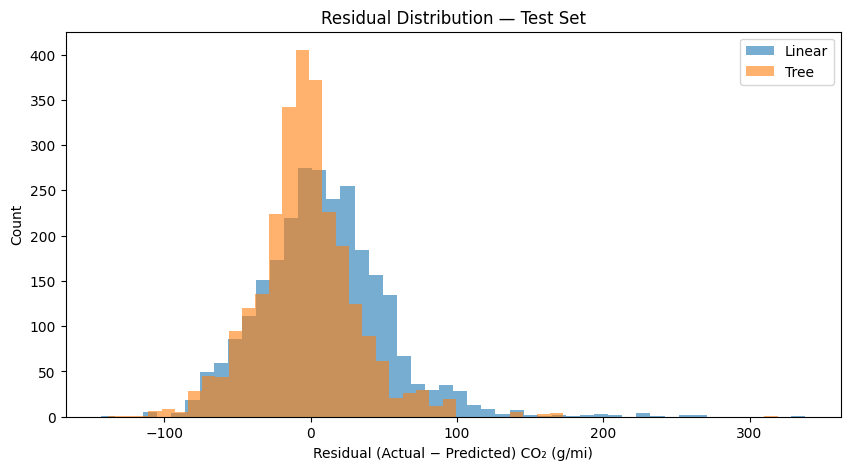

In [ ]:
residuals_lin = y_test - y_test_pred
residuals_gbr = y_test - y_test_pred_gbr

plt.figure(figsize=(10,5))
plt.hist(residuals_lin, bins=50, alpha=0.6, label="Linear")
plt.hist(residuals_gbr, bins=50, alpha=0.6, label="Tree")
plt.xlabel("Residual (Actual − Predicted) CO₂ (g/mi)")
plt.ylabel("Count")
plt.title("Residual Distribution — Test Set")
plt.legend()
plt.show()


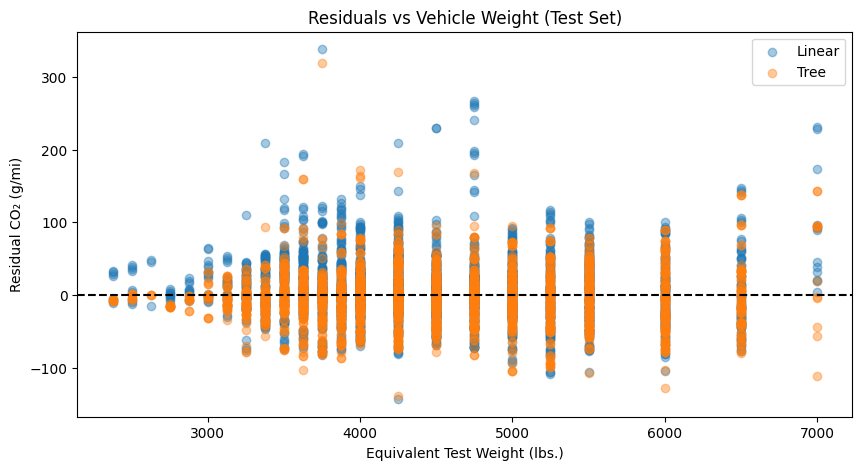

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(
    X_test["Equivalent Test Weight (lbs.)"],
    residuals_lin,
    alpha=0.4,
    label="Linear"
)
plt.scatter(
    X_test["Equivalent Test Weight (lbs.)"],
    residuals_gbr,
    alpha=0.4,
    label="Tree"
)

plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Equivalent Test Weight (lbs.)")
plt.ylabel("Residual CO₂ (g/mi)")
plt.title("Residuals vs Vehicle Weight (Test Set)")
plt.legend()
plt.show()


In [ ]:
# Extract trained tree model
gbr = gbr_model.named_steps["model"]

# Feature names from preprocessor
feature_names = (
    NUM_FEATURES +
    list(
        gbr_model.named_steps["preprocess"]
        .named_transformers_["cat"]
        .get_feature_names_out(CAT_FEATURES)
    )
)

importances = gbr.feature_importances_

fi = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)

plt.figure(figsize=(8,5))
plt.barh(fi["feature"][:10][::-1], fi["importance"][:10][::-1])
plt.xlabel("Feature Importance")
plt.title("Top Feature Importances — Tree Model")
plt.show()


AttributeError: 'HistGradientBoostingRegressor' object has no attribute 'feature_importances_'

In [ ]:
import numpy as np

# Create a reference vehicle
base_vehicle = {
    "Model Year": 2022,
    "Test Veh Displacement (L)": 2.0,
    "Equivalent Test Weight (lbs.)": 3500,
    "drive_bucket": "FWD"
}

transmissions = ["MT", "AT", "CVT"]
rows = []

for t in transmissions:
    row = base_vehicle.copy()
    row["transmission_bucket"] = t
    rows.append(row)

df_sweep = pd.DataFrame(rows)

preds = gbr_model.predict(df_sweep)

plt.figure(figsize=(6,4))
plt.bar(transmissions, preds)
plt.ylabel("Predicted CO₂ (g/mi)")
plt.title("Transmission Sensitivity (Fixed Vehicle)")
plt.show()


In [ ]:
import joblib

joblib.dump(gbr_model, "co2_architecture_tree_model.pkl")
joblib.dump(linreg_model, "co2_architecture_linear_model.pkl")


In [ ]:
import pandas as pd
import numpy as np

# Access trained linear regression model
linreg = linreg_model.named_steps["model"]
preprocessor = linreg_model.named_steps["preprocess"]

# Get numerical feature names
num_features = NUM_FEATURES

# Get categorical feature names after one-hot encoding
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(CAT_FEATURES)

# Combine all feature names
all_features = list(num_features) + list(cat_features)

# Get coefficients
coefficients = linreg.coef_

# Create DataFrame
coef_df = pd.DataFrame({
    "Feature": all_features,
    "Coefficient (g/mi)": coefficients
})

# Add absolute magnitude for sorting
coef_df["Abs_Coefficient"] = coef_df["Coefficient (g/mi)"].abs()

# Sort by magnitude
coef_df_sorted = coef_df.sort_values("Abs_Coefficient", ascending=False)

coef_df_sorted.head(10)


,Feature,Coefficient (g/mi),Abs_Coefficient
1,Test Veh Displacement (L),40.066736,40.066736
4,transmission_bucket_CVT,-31.291164,31.291164
5,transmission_bucket_MT,20.539054,20.539054
3,transmission_bucket_AT,10.752111,10.752111
6,drive_bucket_AWD,9.334392,9.334392
7,drive_bucket_FWD,-8.381305,8.381305
0,Model Year,-2.579294,2.579294
8,drive_bucket_RWD,-0.953086,0.953086
2,Equivalent Test Weight (lbs.),0.026361,0.026361


In [ ]:
top_n = 10
plot_df = coef_df_sorted.head(top_n)


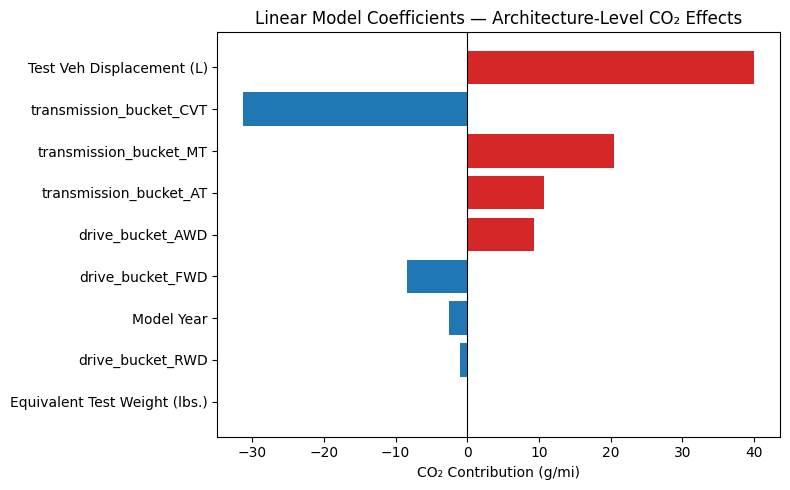

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

colors = plot_df["Coefficient (g/mi)"].apply(
    lambda x: "tab:red" if x > 0 else "tab:blue"
)

plt.barh(
    plot_df["Feature"][::-1],
    plot_df["Coefficient (g/mi)"][::-1],
    color=colors[::-1]
)

plt.axvline(0, color="black", linewidth=0.8)

plt.xlabel("CO₂ Contribution (g/mi)")
plt.title("Linear Model Coefficients — Architecture-Level CO₂ Effects")

plt.tight_layout()
plt.show()
